In this notebook, we will attempt to scale the intensity values of images from HoloMonitor using the image metadata (intensity scaling information from the exif-data, min and max values), and illustrate some of the issues that we have encountered during our rescaling attempts to convert intensity values to optical thickness values. 

Firtly, import the necessary libraries:

In [1]:
import os
import csv
import matplotlib.pyplot as plt  # plotting
import numpy as np  # numerics
from skimage import io
from natsort import natsorted
#import skimage.io
import skimage.color
import skimage.morphology
import skimage.measure as sm

from skimage.io import imread
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from skimage import (io, filters,  morphology, measure, segmentation, feature, util, exposure)
from scipy.ndimage import gaussian_filter 
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom


Read the data - images and min and max values from image metadata:

In [2]:
#define data path, here I am assuming that this notebook is in the same parent folder as the images and the unscaled heights
image_directory_path = '../HoloMonitorData/HoloMonitor_Beta_TIFF/September_2023/MDCK_Edna_06.09.23-B1-1_100ul'
#the csv file contains information about the min and max values of each image 
csv_file_path = './Metadata Analysis/Raw Data/September_2023_MDCK_Edna_06.09.23-B1-1_100ul_minmaxvalues_rawHM.csv'

#read images and save it in image_list 
list_files = [os.path.join(image_directory_path, f) for f in os.listdir(image_directory_path)]
list_files = natsorted(list_files)
image_list = []

#open all images in the stack
for filename in list_files:
    image_list.append(io.imread(filename))

In [3]:
#read height info (min max values) for each image 
# Initialize empty lists to store the data from the CSV file
min_values = []
max_values = []

# Read the CSV file
with open(csv_file_path, 'r') as file:
    # Create a CSV reader
    csv_reader = csv.reader(file)
    
    # Skip the header row if it exists
    header = next(csv_reader, None)
    
    # Iterate through the rows and extract data
    for row in csv_reader:
        min_values.append(float(row[0]))
        max_values.append(float(row[1]))

# Convert the lists to NumPy arrays to make life easier and ensure that  we are operating with floats
min_values_array = np.array(min_values, dtype=float)
max_values_array = np.array(max_values, dtype=float)

#multiply all values by HoloMonitor factor: 15.875
min_values_array = min_values_array*15.875
max_values_array = max_values_array*15.875

We now scale the images according to this formula: 

$$
\hat{I}_{i} = \left(\frac{I}{\Delta I} \cdot \Delta \zeta_{i} + \zeta_{min} - \zeta_{i, min}\right) \cdot 1000 
$$

Here, $\hat{I}_{i}$ represents an array that consists of the transformed intensity values of image $i$ in the stack, $I_{i}$ is the array consisting of the original intensity values, $\Delta I$ is the difference between the maximum and minimum pixel values in the image (magic number 65535), $\Delta \zeta_{i}$ is the difference between the maximum and minimum optical thickness values for each image i in the stack:

$$
\Delta \zeta_{i} = \zeta_{i,max} - \zeta_{i, min}.
$$

$\zeta_{min}$ is the minimum pixel value of the entire stack (the value we expect to be constant and the same for each image), and $\zeta_{i, min}$ is the minimum optical thickness value of image i. The result is multiplied by 1000 to convert the units from micrometers to nanometers.



In [4]:
#define the variables from the formula above 
zeta_min = np.median(min_values_array) #this is the value that we expect to be the same throughout the stack, but it is not for some datasets
delta_zeta_i = max_values_array - min_values_array 
delta_I = 65535

#rescale all images in the stack, and save the rescaled images in a new list called I_hat_all
I_hat_all = [] #scaled optical heights in nanometers for all images in the stack
for i in range(len(image_list)):
    I_hat_all.append(( (image_list[i]/delta_I) * delta_zeta_i[i] + zeta_min - min_values_array[i] ) * 1000)
numpix=np.shape(I_hat_all[0])[0]*np.shape(I_hat_all[0])[1]

Text(0.5, 0, 'Image number')

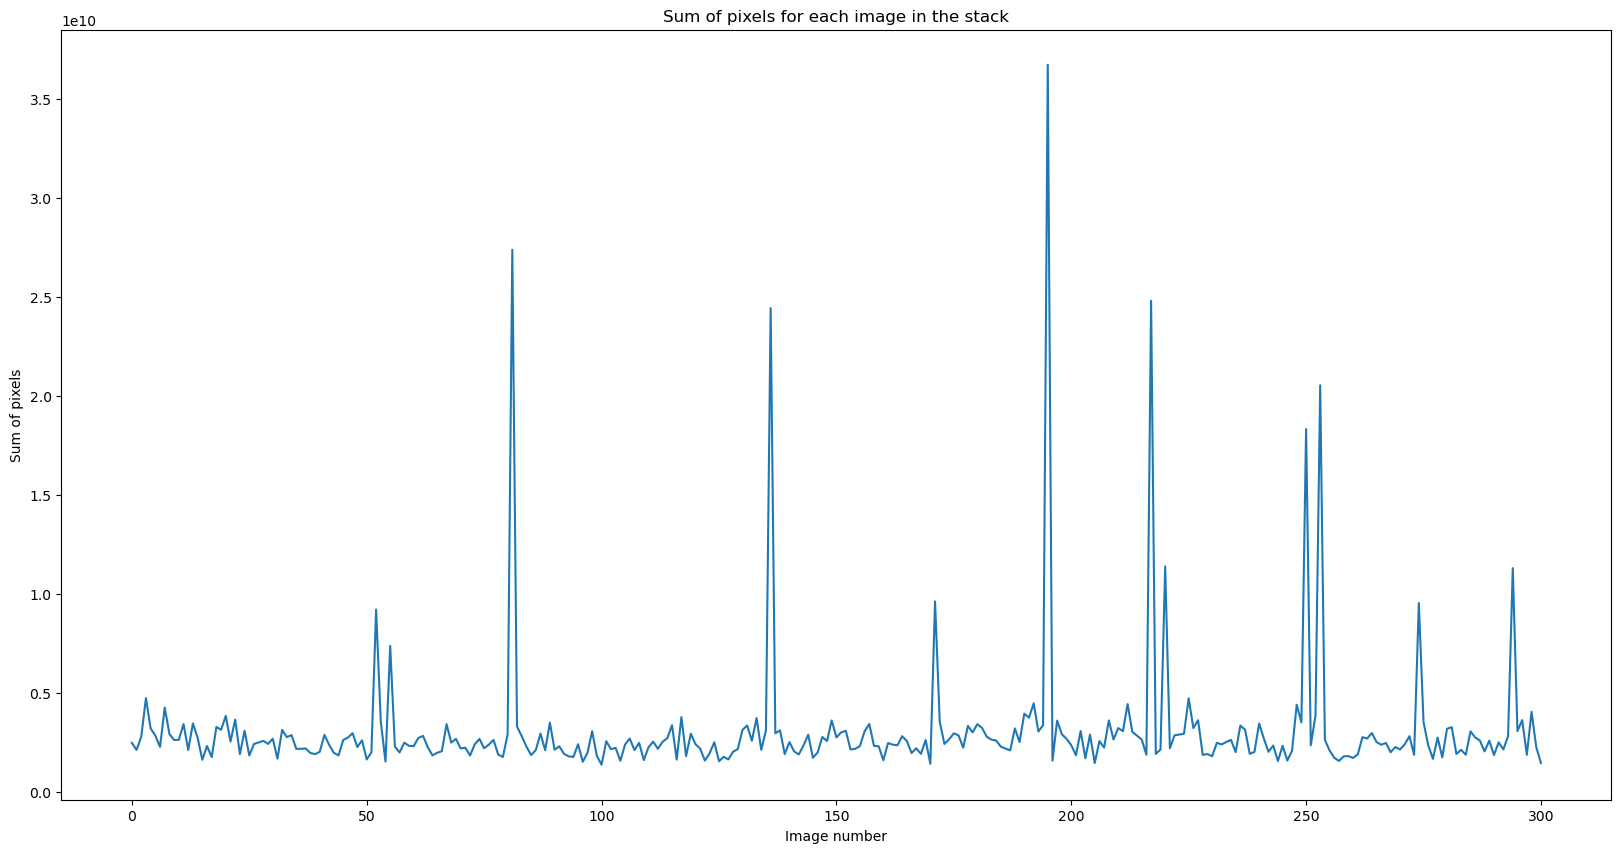

In [5]:
#compute the sum of all pixels for each image in the stack - sum over both axis 
#plot to visualise the sum of pixels for each image in the stack
sum_of_pixels = []
for i in I_hat_all:
    sum_of_pixels.append(np.sum(i))
sum_of_pixels=np.array(sum_of_pixels)
plt.figure(figsize=(20,10))
plt.plot(sum_of_pixels)
plt.title('Sum of pixels for each image in the stack')
plt.ylabel('Sum of pixels')
plt.xlabel('Image number')

The values on the y-axis are negative because the minimum value of the entire stack that we rescaled images with, is an incredibly small number. Even though the majority of minimum values are the same, there are some outliers which are much smaller, and end up rescaling our images in a strange way. 

Either way, from the plot above we see that the sum of pixels is not very constant throughout the stack, which is an issue for us. We expect the sum of the pixels to stay constant since we expect the mass to be conserved throughout the stack. We also see some very large outliers (ca 12 very large peaks), which we would like to rescale to be more in line with the rest of the stack. 

To systematically identify outliers, we define a criterion for the sum of the pixels to fulfill: all image that have a sum of pixels above the median value of the stack plus the standard deviation are outliers:

Standard deviation = 3.50e+09
Criteria for outliers (std + median) = 5.96e+09


Text(0.5, 1.0, 'Sum of pixels for each image in the stack with criterion for outliers')

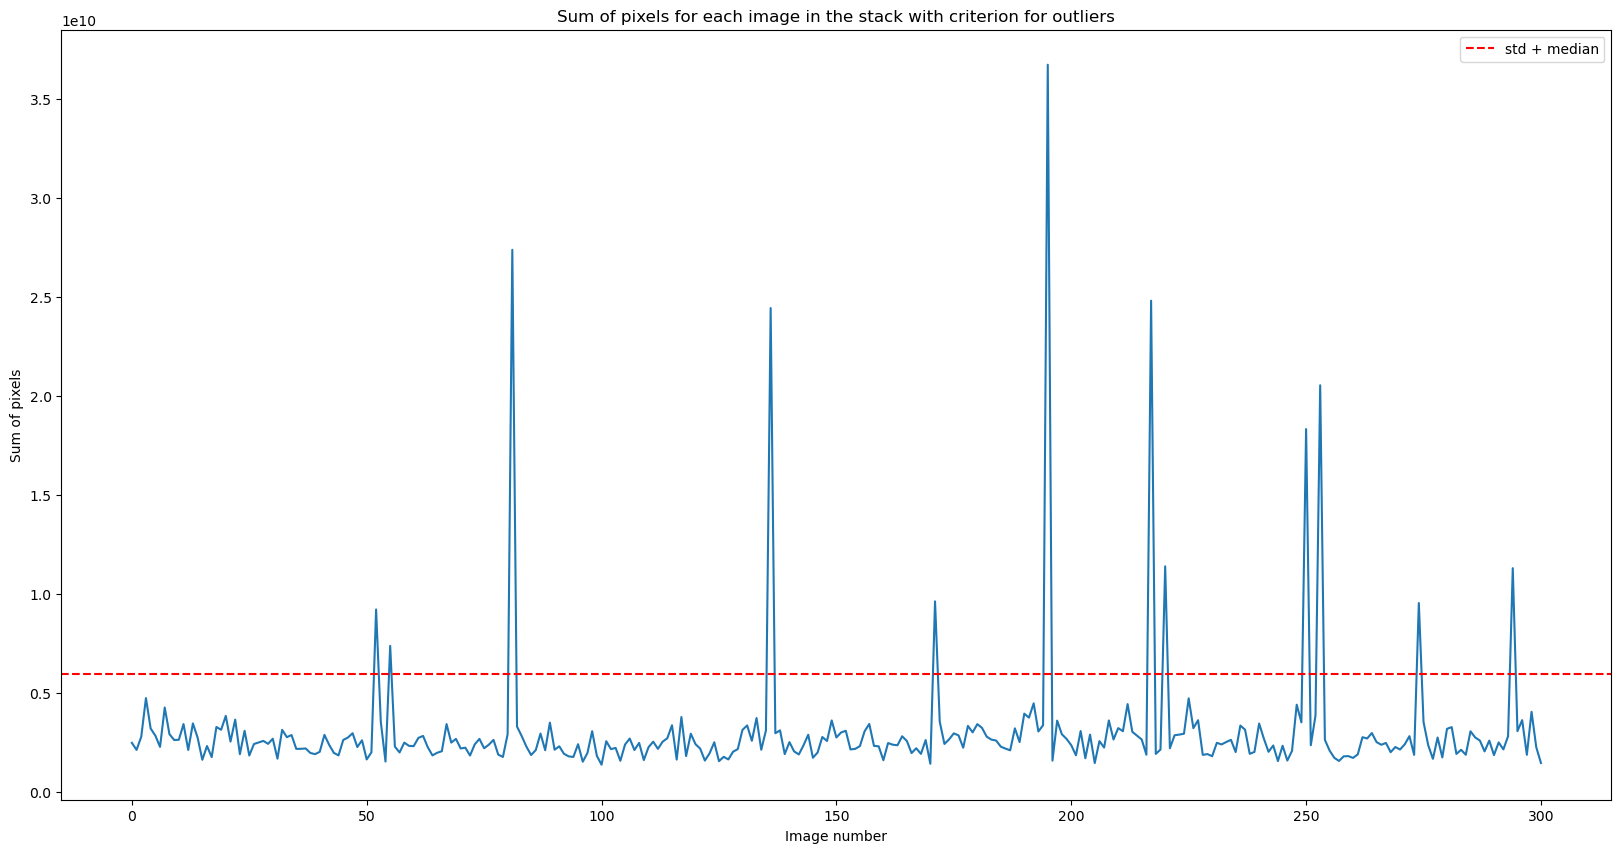

In [6]:
std = np.std(sum_of_pixels)
#print in scientific notation 
print("Standard deviation =", f'{std:.2e}')

median = np.median(sum_of_pixels)
median_std = median + std
print("Criteria for outliers (std + median) =", f'{median_std:.2e}')

plt.figure(figsize=(20,10))
plt.plot(sum_of_pixels)
#plot median_std as a horizontal line
plt.axhline(y=median_std, color='r', linestyle='--', label = 'std + median')
plt.legend()
plt.ylabel('Sum of pixels')
plt.xlabel('Image number')
plt.title('Sum of pixels for each image in the stack with criterion for outliers')

We can now clearly identify the peaks that should be rescaled. To rescale them, we multiply them by the median value of the entire stack, and divide by the sum of pixels in that image:

Text(0.5, 1.0, 'Sum of pixels for each image in the stack after rescaling the outliers')

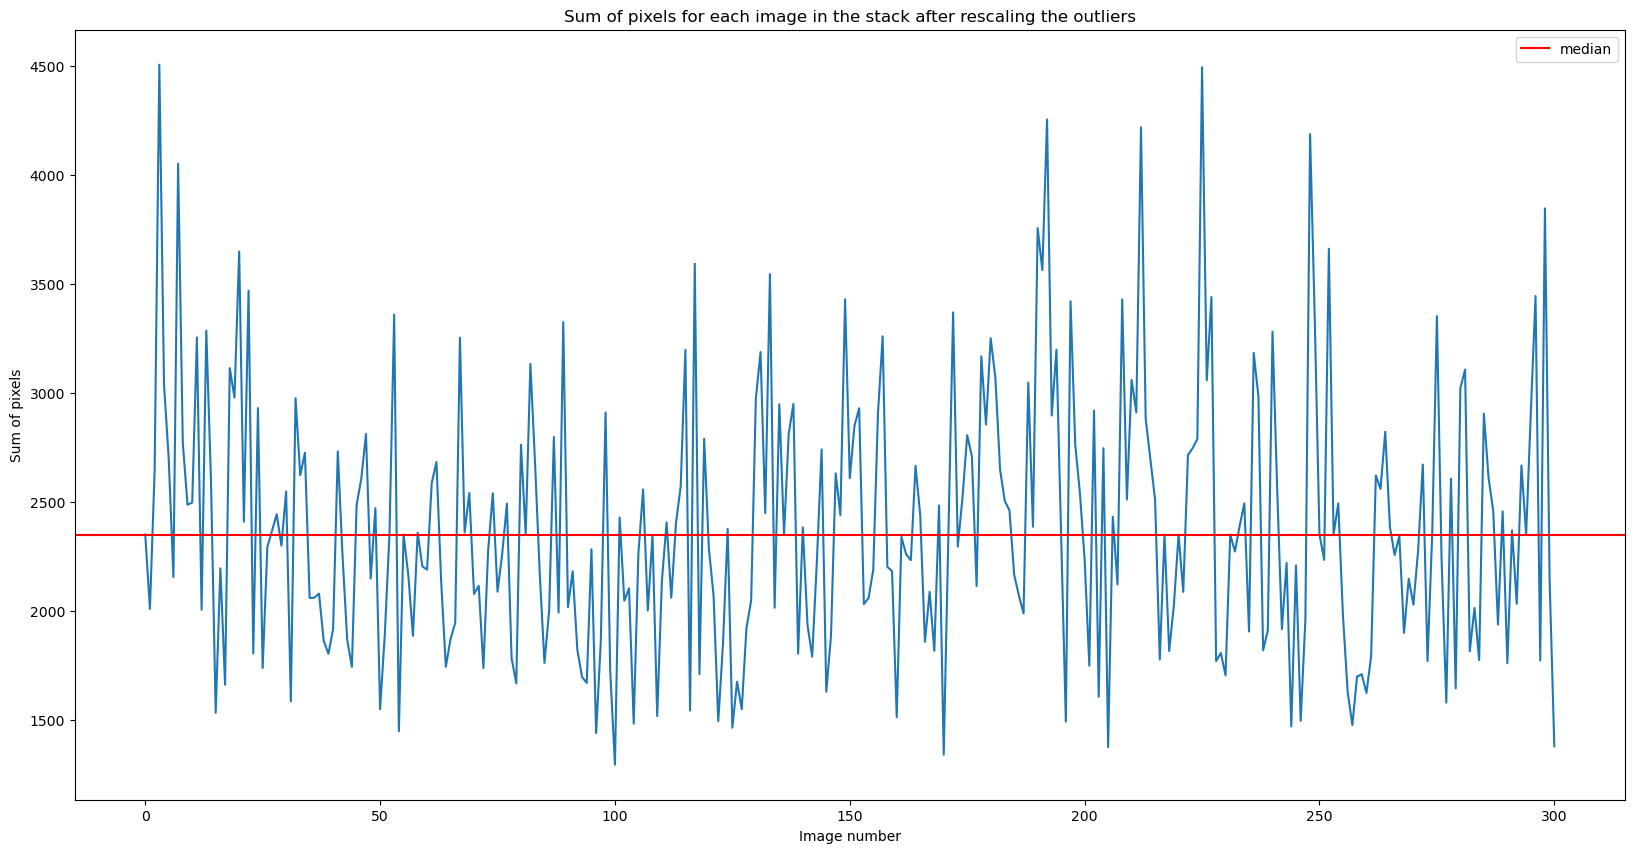

In [7]:
for i in range(len(sum_of_pixels)):
    if sum_of_pixels[i] > median_std:
        I_hat_all[i] = (I_hat_all[i]*median)/sum_of_pixels[i]
        sum_of_pixels[i] = np.sum(I_hat_all[i])
        
plt.figure(figsize=(20,10))
plt.plot(sum_of_pixels/numpix)
plt.axhline(y = median/numpix, color = 'r', linestyle = '-', label = 'median')
plt.legend()
plt.ylabel('Sum of pixels')
plt.xlabel('Image number')
plt.title('Sum of pixels for each image in the stack after rescaling the outliers')



But nevertheless, we see that the fluctuations in the sum of pixels across the entire stack is very high, which is not ideal.

In [8]:
print(np.std(sum_of_pixels)/numpix, 100*np.std(sum_of_pixels)/np.mean(sum_of_pixels))

601.9066583687304 25.21837970593268


The standard deviation of the mean height of the layer of cells is 25% of the mean height. This is not impressive. From the video of images we see clearly that this strongly fluctuating mean intensity is an artefact that should be easily corrected for.

The standard deviation of the mean cell height $\langle h\rangle$ is $\sigma_{\langle h\rangle}=600$ nm. If we assume that the accuracy of each pixel is $\sigma_{h}=1000$ nm as stated in the tender documents from HoloMonitor the accuracy of the mean value should be $\sigma_{\langle h\rangle}=\sigma_{h}/\sqrt{N}$, where $\sqrt{N}=1024$. Thus we expected the standard deviation of the mean to be $\sigma_{\langle h\rangle}=1$ nm, not 600 nm.